In [1]:
# Modules

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Make NumPy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)

import sys
sys.path.insert(0,'../')  # add previous directory to path to load constants module
import constants as const

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import keras_tuner as kt
print(tf.__version__)

from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, r2_score
import statistics


2025-01-24 13:25:10.071296: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-24 13:25:10.104897: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-01-24 13:25:10.572247: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


2.12.0


In [2]:
# Load existing Pphys model
from keras import backend as K
from keras.layers import Input, Lambda
from keras.layers import Concatenate
Cp_max = 0.5926
V_mean = 6.314169410268349
V_std = 1.9826865496833004

Pphys_model = tf.keras.models.load_model('../Models/Pphys_Cp3D.h5')
Pphys_model._name = "model_phys"
Pphys_model.summary()

Model: "model_phys"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 xphys (InputLayer)             [(None, 3)]          0           []                               
                                                                                                  
 lambda (Lambda)                (None, 1)            0           ['xphys[0][0]']                  
                                                                                                  
 sequential_1 (Sequential)      (None, 1)            17153       ['xphys[0][0]']                  
                                                                                                  
 lambda_3 (Lambda)              (None, 1)            0           ['lambda[0][0]',                 
                                                                  'sequential_1[0][0]']  

2025-01-24 13:25:12.423805: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


In [3]:
# Load existing Pres model
Pres_norm_model = tf.keras.models.load_model('../Models/Pres_Cp3D_CF.h5')
Pres_norm_model._name = "model_res_norm"
Pres_norm_model.summary()

Model: "model_res_norm"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 128)               1152      
                                                                 
 dense_9 (Dense)             (None, 128)               16512     
                                                                 
 dense_10 (Dense)            (None, 1)                 129       
                                                                 
Total params: 17,793
Trainable params: 17,793
Non-trainable params: 0
_________________________________________________________________


In [4]:
# Define non-normalized Pres

import numpy as np
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Lambda

# Define Pres model to output the residual power in original units
#Pres_mean = 590.292648
#Pres_std = 30315.169840
Pres_mean = 548.729493
Pres_std = 30275.282659

input_shape = Pres_norm_model.input_shape[1:]  # Get the input shape of normalized Pres model
input_layer = Input(shape=input_shape)

# Normalized output
output_norm = Pres_norm_model(input_layer)
# Scale the output
output_new = Lambda(lambda x: x * Pres_std + Pres_mean)(output_norm)

# Define the new model
Pres_model = Model(inputs=input_layer, outputs=output_new)
Pres_model._name = "model_res"

# Optional: Compile the new model if you plan to train it further
#Pres_model.compile(optimizer='adam', loss='mean_squared_error')

# Print the model summary to verify
Pres_model.summary()

Model: "model_res"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 8)]               0         
                                                                 
 model_res_norm (Sequential)  (None, 1)                17793     
                                                                 
 lambda (Lambda)             (None, 1)                 0         
                                                                 
Total params: 17,793
Trainable params: 17,793
Non-trainable params: 0
_________________________________________________________________


In [7]:
Pres_model.save('../Models/Pres_Cp3D_CF_unnorm.h5')

In [6]:
# Define non-normalized Phybrid as Pphys + Pres

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Add, Lambda
import tensorflow.keras.backend as K

# Add Pphys and Pres to obtain the Phybrid model
print(Pphys_model.input_shape)
print(Pres_model.input_shape)

# Pphys has one input of shape (None, 3), and Pres has one input of shape (None, 8)

# Define the global input layer (shape is (None, 8))
global_input = Input(shape=(8,))

# Take variables V, theta, and W, at indices 2, 0, and 5 for the phys submodel
Pphys_input = Lambda(lambda x: K.stack([x[:, 2], x[:, 0], x[:, 5]], axis=1))(global_input)

# Evaluate two submodels
Pres_output = Pres_model(global_input)  
Pphys_output = Pphys_model(Pphys_input)  

# Sum the outputs of the two submodels and create the global model
Phybrid_output = Pres_output + Pphys_output
#Phybrid_output = Add()([Pphys_output, Pres_output])
Phybrid_model = Model(inputs=global_input, outputs=Phybrid_output)
Phybrid_model._name = "model_hybrid"

tf.keras.utils.plot_model(Phybrid_model, to_file='Phybrid_Cp3D_CF_model.png', show_shapes=True, show_layer_names=True)

# Compile the model if needed if you plan to train it further
#Phybrid_model.compile(optimizer='adam', loss='mse')

# Check the model summary
Phybrid_model.summary()


(None, 3)
(None, 8)
Model: "model_hybrid"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 8)]          0           []                               
                                                                                                  
 lambda_2 (Lambda)              (None, 3)            0           ['input_3[0][0]']                
                                                                                                  
 model_res (Functional)         (None, 1)            17793       ['input_3[0][0]']                
                                                                                                  
 model_phys (Functional)        (None, 1)            17153       ['lambda_2[0][0]']               
                                                                   

In [7]:
# Load on test dataset
test_dataset = pd.read_csv('../Datasets/Dataset_test_CF.csv')
print("Shape of dataset: "+str(test_dataset.shape))
test_dataset.tail()

Shape of dataset: (120530, 9)


,Unnamed: 0,theta,nacelle_temperature,V,Vane_angle,Out_temperature,W,Rotor_temperature,Wind_angle_c
120525,602624,2.261595,-1.446023,6.246994,-1.062332,-0.523592,1.372620,0.153446,-1.102609
120526,602627,2.731609,-0.858250,6.448740,0.734560,0.195539,1.369336,-0.020485,-1.229932
120527,602631,2.669721,-1.336219,6.473959,0.372848,-0.362845,1.375905,0.055875,-0.773930
120528,602632,2.867093,-1.069784,6.514308,-0.170250,0.060173,1.369336,0.363437,-1.329537
120529,602633,2.885492,-0.917996,6.549613,-0.723956,0.058763,1.369336,0.480099,1.842357


In [8]:
# Check overal statistis of each input feature 
test_dataset.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Unnamed: 0,120530.0,301534.635443,174263.658860,2.000000,150020.500000,301226.500000,453104.500000,602633.000000
theta,120530.0,-0.002931,0.982693,-0.167090,-0.153709,-0.152036,-0.136982,15.483876
nacelle_temperature,120530.0,-0.004597,1.001883,-3.730909,-0.646717,0.078311,0.703223,2.957428
V,120530.0,0.002711,1.000811,-3.068649,-0.677954,-0.213937,0.416521,6.549613
Vane_angle,120530.0,0.001283,0.988996,-18.768196,-0.546813,-0.029172,0.531959,18.990949
Out_temperature,120530.0,-0.005168,0.999561,-2.586509,-0.784453,-0.083653,0.680599,3.707996
W,120530.0,0.001322,0.998621,-4.273043,-0.847548,-0.039617,0.955517,1.379188
Rotor_temperature,120530.0,-0.004259,0.998383,-5.147225,-0.635609,0.004968,0.662515,3.729650
Wind_angle_c,120530.0,-0.002968,0.998798,-1.347419,-0.910105,-0.282700,0.759755,1.871326


(120530, 8)
3767/3767 [==============================] - 1s 351us/step


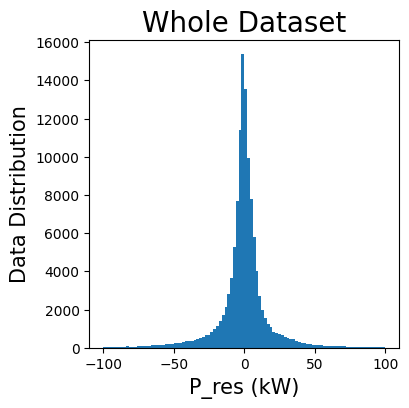

3767/3767 [==============================] - 2s 441us/step


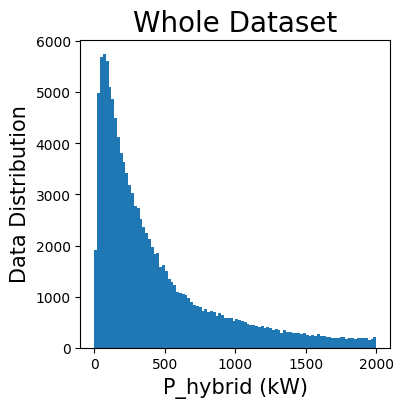

(120530, 3)
3767/3767 [==============================] - 1s 372us/step


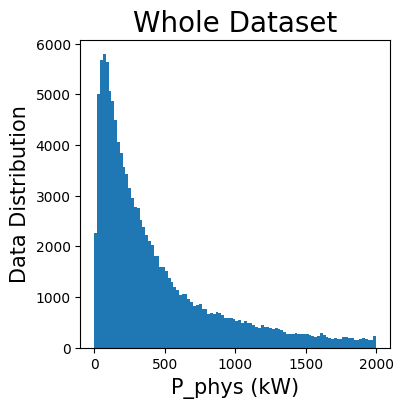

In [9]:
# Plot distributions of P_res in kW
selected_columns = test_dataset.iloc[:,1:9]
x_input = selected_columns.to_numpy()
print(x_input.shape)
Pres_data = Pres_model.predict(x_input)
plt.figure(figsize=(4,4))
#plt.hist(Pres_data, range=[2.5, 15], bins=100)
plt.hist(Pres_data/1000, range=[-100, 100], bins=100)
plt.xlabel('P_res (kW)',fontsize=15)
plt.ylabel('Data Distribution',fontsize=15)
plt.title('Whole Dataset',fontsize=20)
plt.show()

# Plot distribution of P_hybrid in kW
Phybrid_data = Phybrid_model.predict(x_input)
plt.figure(figsize=(4,4))
#plt.hist(Pres_data, range=[2.5, 15], bins=100)
plt.hist(Phybrid_data/1000, range=[0, 2000], bins=100)
plt.xlabel('P_hybrid (kW)',fontsize=15)
plt.ylabel('Data Distribution',fontsize=15)
plt.title('Whole Dataset',fontsize=20)
plt.show()

# Plot distribution of P_phys in kW
selected_columns = test_dataset[['V', 'theta', 'W']]
xphys_input = selected_columns.to_numpy()
print(xphys_input.shape)
Pphys_data = Pphys_model.predict(xphys_input)
plt.figure(figsize=(4,4))
#plt.hist(Pres_data, range=[2.5, 15], bins=100)
plt.hist(Pphys_data/1000, range=[0, 2000], bins=100)
plt.xlabel('P_phys (kW)',fontsize=15)
plt.ylabel('Data Distribution',fontsize=15)
plt.title('Whole Dataset',fontsize=20)
plt.show()

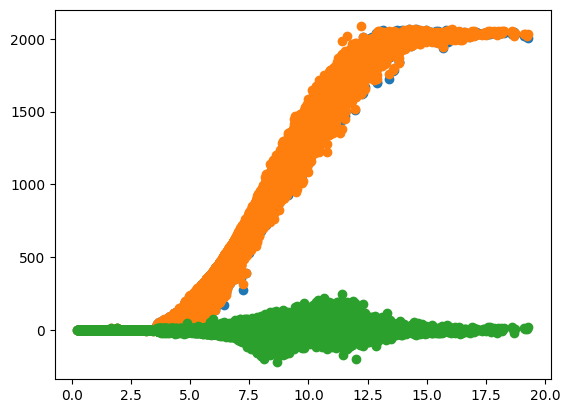

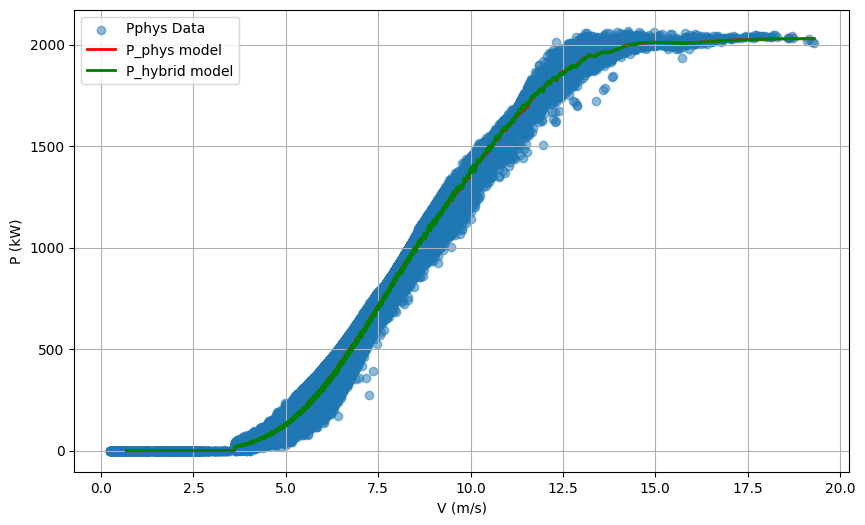

In [10]:
V_original = xphys_input[:,0] * V_std + V_mean
plt.scatter(V_original,Pphys_data/1000)
plt.scatter(V_original,Phybrid_data/1000)
plt.scatter(V_original,Pres_data/1000)
plt.show()

from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

x = V_original
y = Pphys_data
yh = Phybrid_data


# Sort the x and corresponding y values
sorted_indices = np.argsort(x)
x_sorted = x[sorted_indices]
y_sorted = y[sorted_indices]
yh_sorted = yh[sorted_indices]

# Ensure y_sorted is a 1D vector (it should be, but we can use ravel() to be sure)
y_sorted = y_sorted.ravel()  # This ensures it's a 1D array
yh_sorted = yh_sorted.ravel()  # This ensures it's a 1D array

# Calculate moving average
window_size = 100
# Use np.convolve with 'valid' mode to handle edges properly
y_smoothed = np.convolve(y_sorted, np.ones(window_size)/window_size, mode='valid')
yh_smoothed = np.convolve(yh_sorted, np.ones(window_size)/window_size, mode='valid')

# Plotting
plt.figure(figsize=(10, 6))
plt.scatter(x_sorted, y_sorted/1000, label='Pphys Data', alpha=0.5)
plt.plot(x_sorted[window_size-1:], y_smoothed/1000, color='red', label='P_phys model', linewidth=2)
plt.plot(x_sorted[window_size-1:], yh_smoothed/1000, color='green', label='P_hybrid model', linewidth=2)
#plt.title('Moving Average Smoothing with Unordered Data')
plt.xlabel('V (m/s)')
plt.ylabel('P (kW)')
plt.legend()
plt.grid()
plt.show()

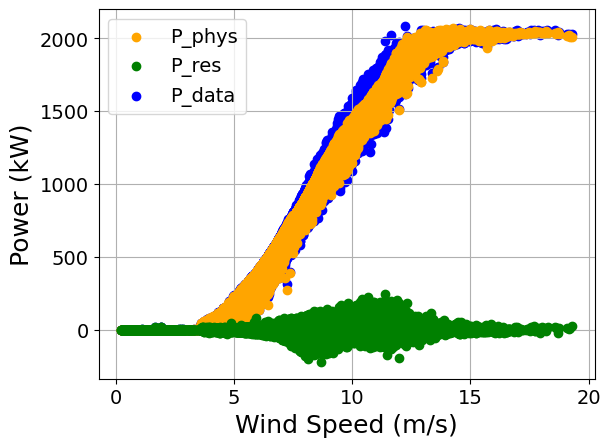

In [30]:
V_original = xphys_input[:,0] * V_std + V_mean
plt.scatter(V_original,Pphys_data/1000,color='orange',label='P_phys',zorder=2)
plt.scatter(V_original,Pres_data/1000,color='green',label='P_res',zorder=3)
plt.scatter(V_original,Phybrid_data/1000,color='blue',label='P_data',zorder=1)

plt.xlabel('Wind Speed (m/s)',fontsize='18')
plt.ylabel('Power (kW)',fontsize='18')

# Adjust the size of x and y ticks
plt.tick_params(axis='x', labelsize=14)  # X-axis tick font size
plt.tick_params(axis='y', labelsize=14)  # Y-axis tick font size

plt.legend(fontsize='14')
plt.grid()
plt.show()

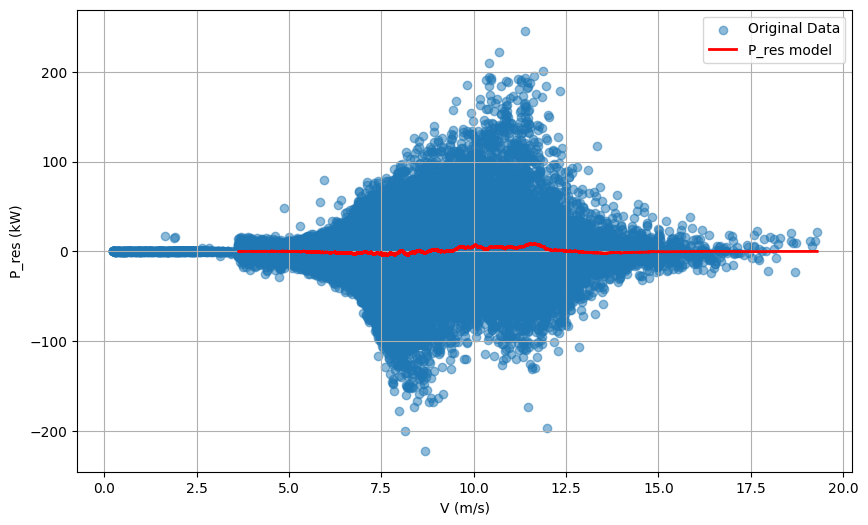

In [21]:
# Plot Pres vs V
x = V_original
y = Pres_data

# Sort the x and corresponding y values
sorted_indices = np.argsort(x)
x_sorted = x[sorted_indices]
y_sorted = y[sorted_indices]

# Ensure y_sorted is a 1D vector (it should be, but we can use ravel() to be sure)
y_sorted = y_sorted.ravel()  # This ensures it's a 1D array

# Calculate moving average
window_size = 1000
# Use np.convolve with 'valid' mode to handle edges properly
y_smoothed = np.convolve(y_sorted, np.ones(window_size)/window_size, mode='valid')

# Plotting
plt.figure(figsize=(10, 6))
plt.scatter(x_sorted, y_sorted/1000, label='Original Data', alpha=0.5)
plt.plot(x_sorted[window_size-1:], y_smoothed/1000, color='red', label='P_res model', linewidth=2)
#plt.title('Moving Average Smoothing with Unordered Data')
plt.xlabel('V (m/s)')
plt.ylabel('P_res (kW)')
plt.legend()
plt.grid()
plt.show()

In [18]:
# Define non-normalized Ptotal as Pphys + Pres with 3+8=11 input variables

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Add, Lambda
import tensorflow.keras.backend as K

# Add Pphys and Pres to obtain the Phybrid model
print(Pphys_model.input_shape)
print(Pres_model.input_shape)

# Pphys has one input of shape (None, 3), and Pres has one input of shape (None, 8)

# Define the global input layer (shape is (None, 11))
total_input = Input(shape=(11,))

# Take variables V, theta, and W, at indices 0, 1, and 2 for the phys submodel
Pphys_input = Lambda(lambda x: K.stack([x[:,0], x[:,1], x[:,2]], axis=1))(total_input)
# Take variables for the residual submodel
Pres_input = Lambda(lambda x: K.stack([x[:,3],x[:,4],x[:,5],x[:,6],x[:,7],x[:,8],x[:,9],x[:,10]], axis=1))(total_input)

# Evaluate two submodels
Pphys_output = Pphys_model(Pphys_input)  
Pres_output = Pres_model(Pres_input)

# Sum the outputs of the two submodels and create the global model
Ptotal_output = Pphys_output + Pres_output
#Phybrid_output = Add()([Pphys_output, Pres_output])
Ptotal_model = Model(inputs=total_input, outputs=Ptotal_output)

tf.keras.utils.plot_model(Ptotal_model, to_file='Ptotal_Cp3D_model.png', show_shapes=True, show_layer_names=True)

# Compile the model if needed if you plan to train it further
#Phybrid_model.compile(optimizer='adam', loss='mse')

# Check the model summary
Ptotal_model.summary()

(None, 3)
(None, 8)
Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_6 (InputLayer)        [(None, 11)]                 0         []                            
                                                                                                  
 lambda_5 (Lambda)           (None, 3)                    0         ['input_6[0][0]']             
                                                                                                  
 lambda_6 (Lambda)           (None, 8)                    0         ['input_6[0][0]']             
                                                                                                  
 model (Functional)          (None, 1)                    17153     ['lambda_5[0][0]']            
                                                                        

In [19]:
Ptotal_model.save('../Models/Ptotal_Cp3D.h5')

/home/alfonso/Work/UGR/Calculations/WindTurbines_hybrid/WT_hybrid_venv/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
Ptotal_model = tf.keras.models.load_model('../Models/Ptotal_Cp3D.h5')
Ptotal_model.summary()


Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_6 (InputLayer)        [(None, 11)]                 0         []                            
                                                                                                  
 lambda_5 (Lambda)           (None, 3)                    0         ['input_6[0][0]']             
                                                                                                  
 lambda_6 (Lambda)           (None, 8)                    0         ['input_6[0][0]']             
                                                                                                  
 model (Functional)          (None, 1)                    17153     ['lambda_5[0][0]']            
                                                                                            